In [1]:
import pyhive
import pandas as pd
from pyhive import presto
 
presto_cursor = pyhive.presto.connect(host='presto.internal.adroll.com',
                               port=8443, username='rachel.zhang@nextroll.com',
                               catalog='hive', schema='adroll').cursor()
 
# executes the specified query and returns the results as a pandas DataFrame
def presto(query):
    presto_cursor.execute(query)
    return pd.DataFrame(presto_cursor.fetchall(), columns=[x[0] for x in presto_cursor.description])

In [2]:
import requests
from requests.auth import HTTPBasicAuth
def presto_df(query, host='presto.internal.adroll.com', port=8443):

    req_kw = { 'auth': HTTPBasicAuth('rachel.zhang@nextroll.com', 'zxcvbnm123!') }

    cursor=pyhive.presto.connect(host='presto.internal.adroll.com',
                                     port=8443,
                                     username='rzhang',
                                     protocol='https',
                                     requests_kwargs=req_kw).cursor()

    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns=[x[0] for x in cursor.description])
    cursor.close()
    return df

In [3]:
query = '''
select adm_date as ds, sum(adm_spend) as y from bi.advertisable_daily_metrics 
where date(adm_date) between date('2020-04-01') and date('2021-12-31') and
      adm_ops_department like '%%RollWorks%%' and
      adm_ops_department not in ('Fraud - GLOBAL - Exclude', 'AdRoll Internal')
group by adm_date
order by 1
'''

In [4]:
df_all = presto_df(query)

In [5]:
df_all.head()

ds              y
0  2020-04-01  153539.738048
1  2020-04-02  168340.289287
2  2020-04-03  163173.605265
3  2020-04-04   92424.963534
4  2020-04-05   99158.250247

In [6]:
df_all['ds'] = pd.to_datetime(df_all['ds'])

In [7]:
quaterly_df = df_all.resample('QS', on = 'ds').sum().reset_index()
quaterly_df

ds             y
0 2020-04-01  1.376479e+07
1 2020-07-01  1.746310e+07
2 2020-10-01  2.046705e+07
3 2021-01-01  2.084223e+07
4 2021-04-01  2.132499e+07
5 2021-07-01  2.073604e+07
6 2021-10-01  1.963431e+07

In [8]:
validation_df = df_all[(df_all['ds']>='2021-10-01') & (df_all['ds']<='2021-12-31')]

In [9]:
df = df_all[(df_all['ds']<'2021-10-01')]

In [10]:
df.describe()

y
count     548.000000
mean   209120.798976
std     68715.378626
min     69765.677961
25%    148423.567220
50%    216341.513912
75%    254899.861027
max    543752.634142

In [11]:
weekly_df = df.resample('w', on = 'ds', label = 'left').sum()
weekly_df.reset_index(inplace = True)
weekly_df.tail()

ds             y
74 2021-08-29  1.407023e+06
75 2021-09-05  1.478290e+06
76 2021-09-12  1.656570e+06
77 2021-09-19  1.820900e+06
78 2021-09-26  1.352929e+06

In [12]:
monthly_df = df.resample('MS', on = 'ds').sum()
monthly_df.reset_index(inplace = True)
monthly_df.head()

ds             y
0 2020-04-01  4.794438e+06
1 2020-05-01  3.843611e+06
2 2020-06-01  5.126746e+06
3 2020-07-01  6.019321e+06
4 2020-08-01  5.063579e+06

In [13]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


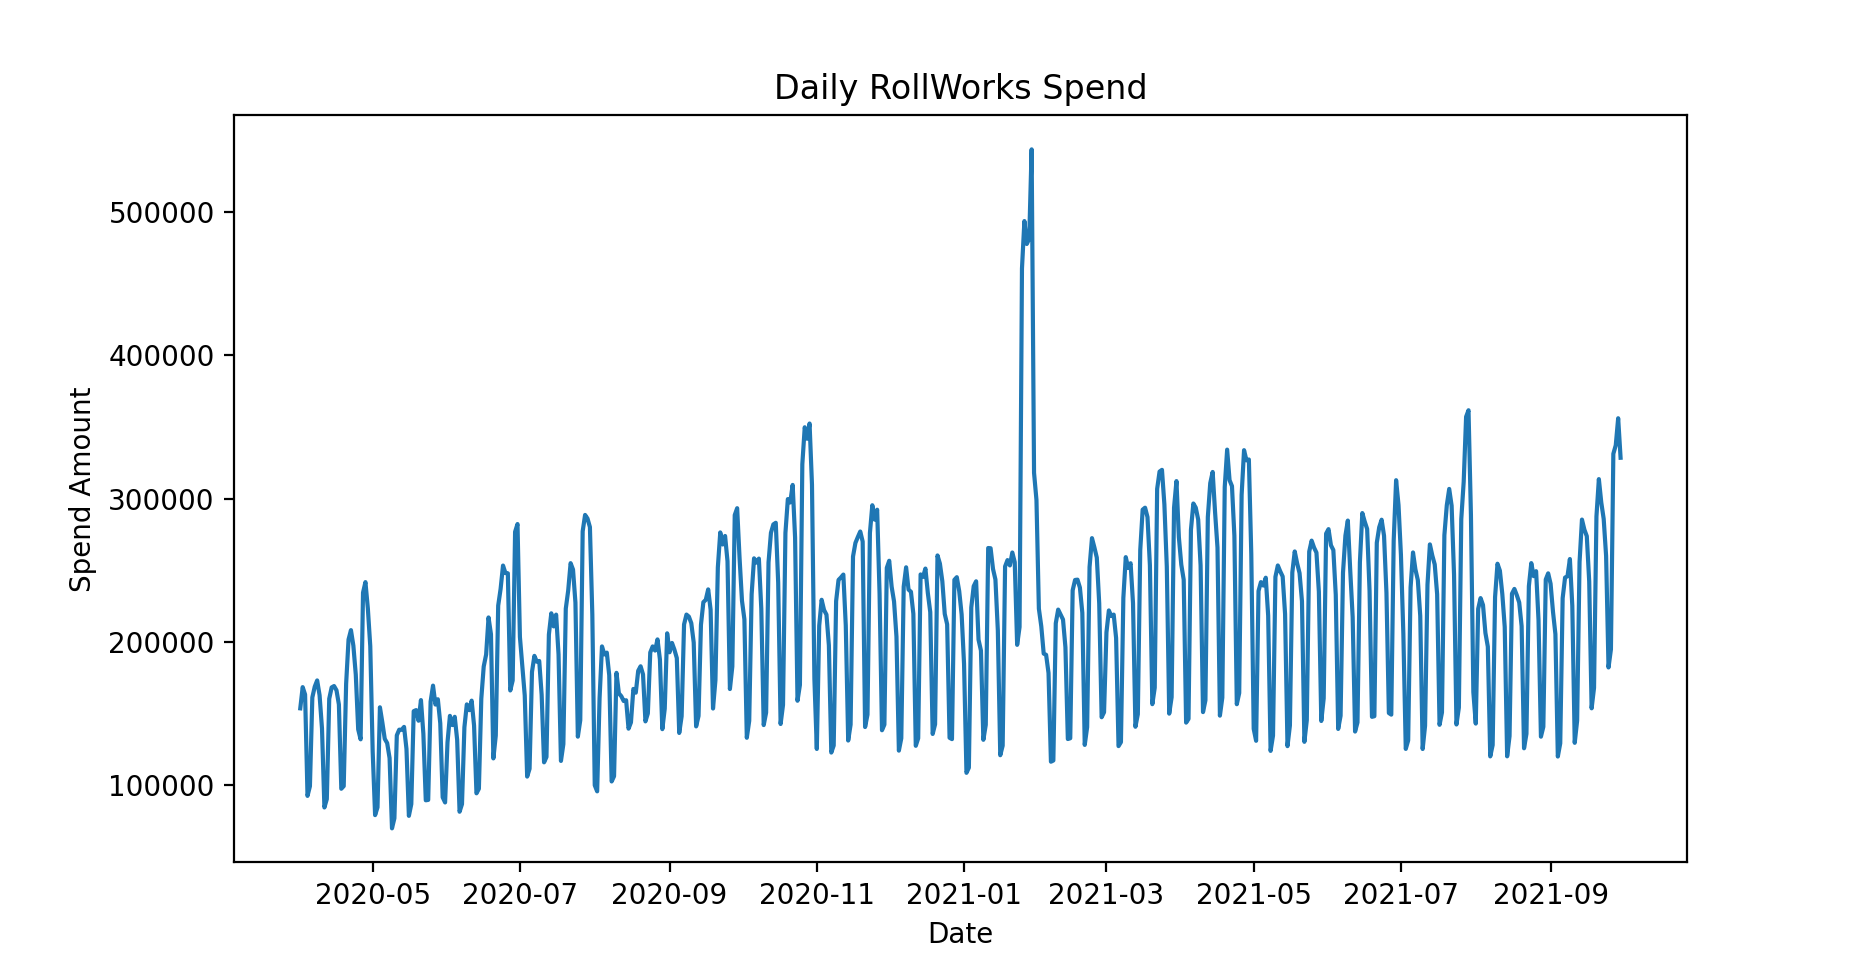

Text(0, 0.5, 'Spend Amount')

In [14]:
plt.plot(df['ds'], df['y'])
plt.title('Daily RollWorks Spend')
plt.xlabel('Date')
plt.ylabel('Spend Amount')

<IPython.core.display.Javascript object>


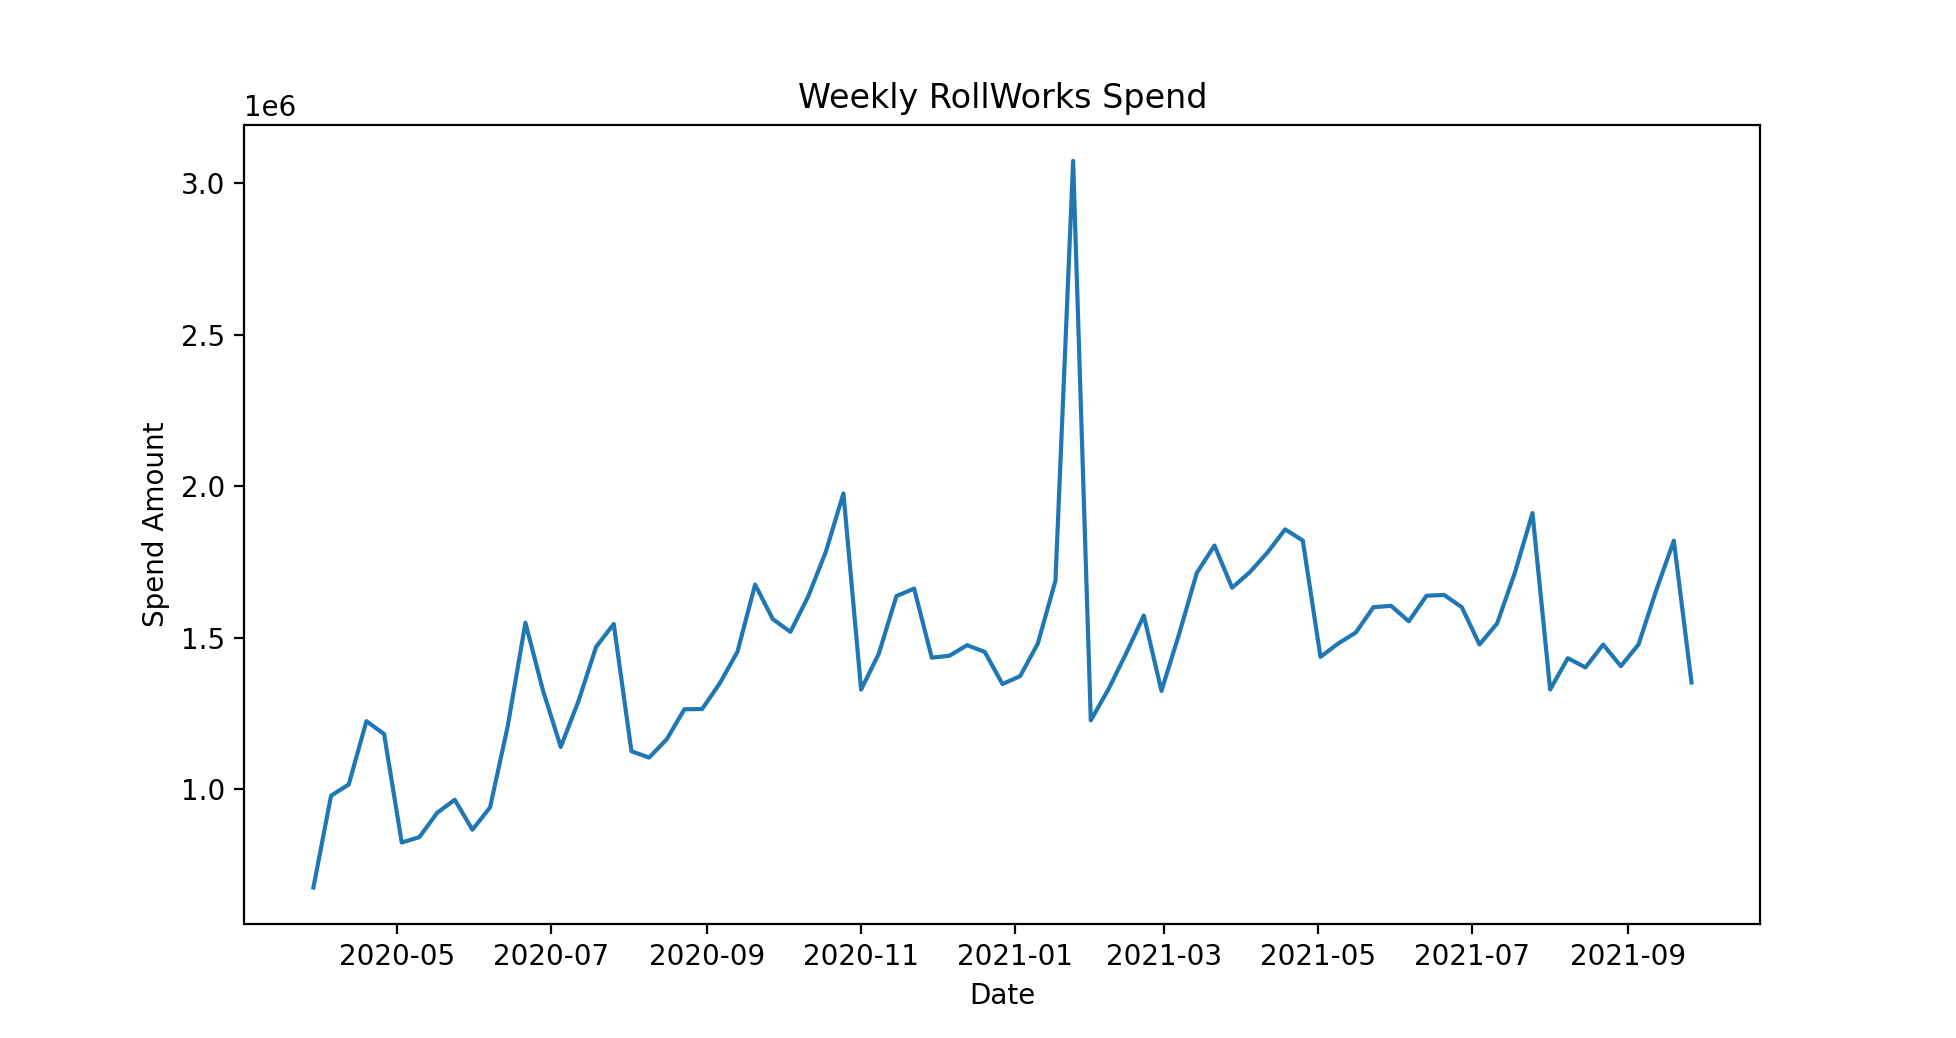

Text(0, 0.5, 'Spend Amount')

In [15]:
plt.plot(weekly_df['ds'], weekly_df['y'])
plt.title('Weekly RollWorks Spend')
plt.xlabel('Date')
plt.ylabel('Spend Amount')

<IPython.core.display.Javascript object>


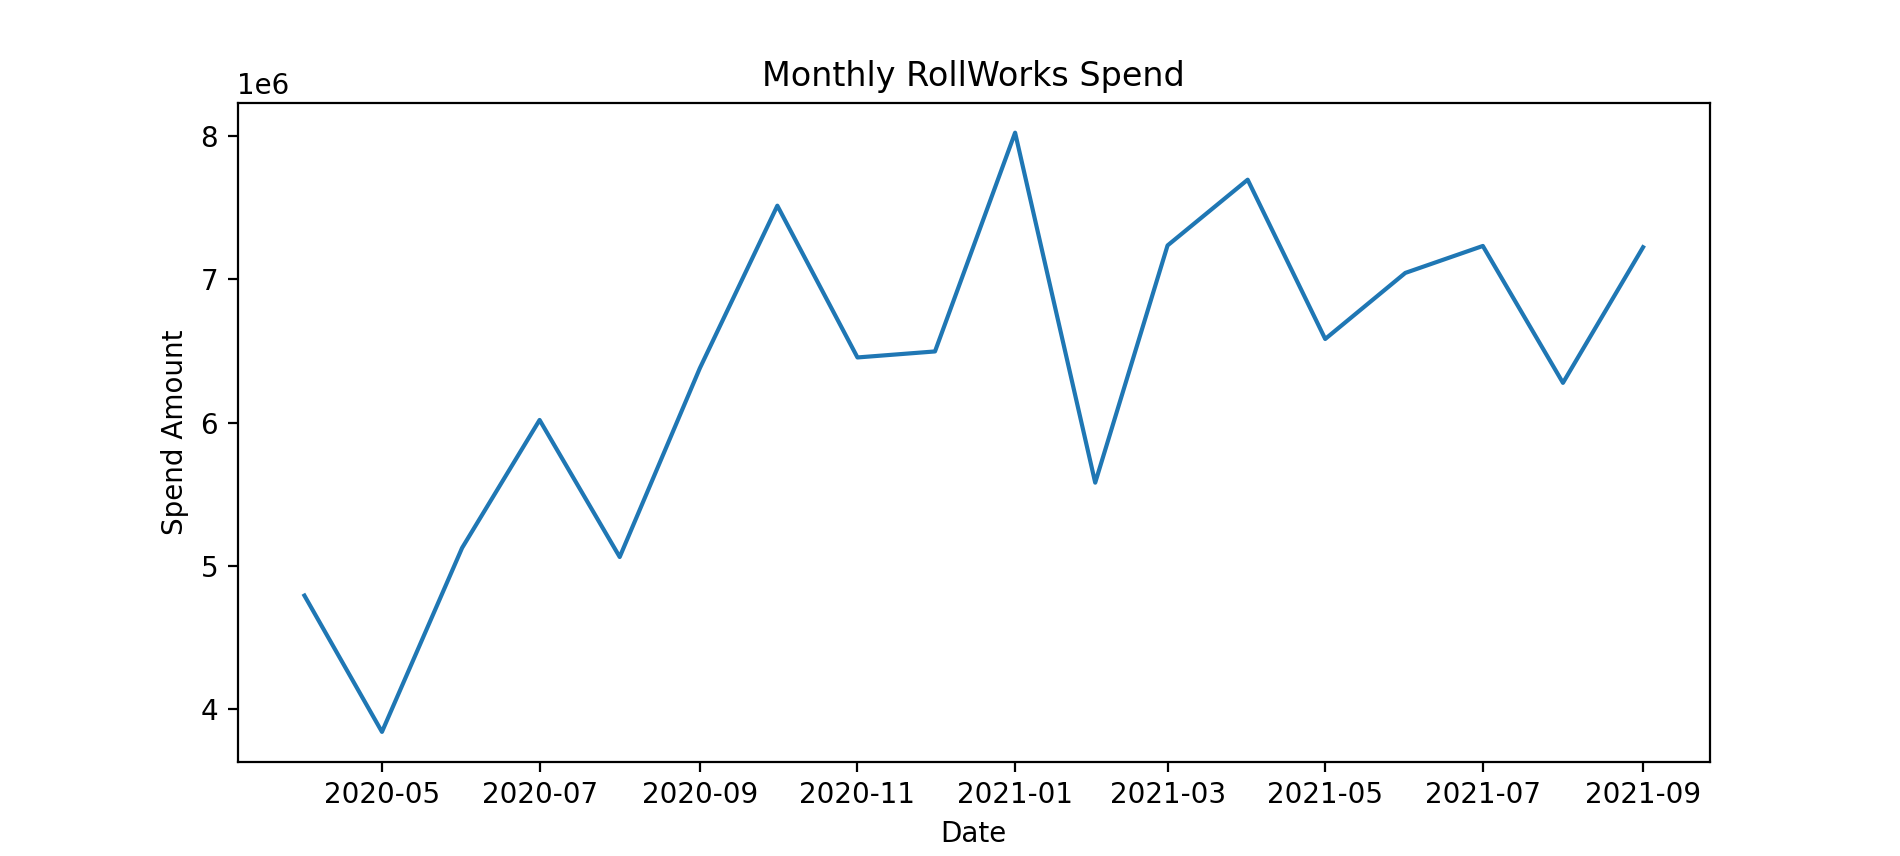

Text(0, 0.5, 'Spend Amount')

In [16]:
plt.plot(monthly_df['ds'], monthly_df['y'])
plt.title('Monthly RollWorks Spend')
plt.xlabel('Date')
plt.ylabel('Spend Amount')

In [17]:
import pandas as pd
from prophet import Prophet

# daily prediction model

In [18]:
# Step 1: Build up model
model = Prophet(seasonality_mode='additive', interval_width=0.95, 
               daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)
model.add_seasonality(name='quarterly', period=91.25, fourier_order=8, prior_scale=0.02)
model.add_country_holidays(country_name='US')

In [19]:
# Step 2: fit model with data
model.fit(df)

Initial log joint probability = -7.30418


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1439.68   0.000754771        130.21           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       1439.93   0.000115895       76.8052   5.403e-07       0.001      223  LS failed, Hessian reset 
     152       1440.06   0.000101158        78.961   2.028e-06       0.001      276  LS failed, Hessian reset 
     160       1440.06   5.13265e-05       54.5498   1.014e-06       0.001      327  LS failed, Hessian reset 
     186       1440.07   7.90784e-05       54.4374   1.769e-06       0.001      411  LS failed, Hessian reset 
     198       1440.08   2.29771e-06       36.9988   4.463e-08       0.001      467  LS failed, Hessian reset 
     199       1440.08   8.03568e-07       43.1683      0.8741      0.8741      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  No

In [20]:
#Step 3: predict future data
future = model.make_future_dataframe(periods=92, freq = 'D' )
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

ds           yhat     yhat_lower     yhat_upper
635 2021-12-27  229642.694319  183143.698682  277519.609047
636 2021-12-28  250203.007894  205137.098558  295760.234308
637 2021-12-29  247868.006993  203199.846630  292311.748548
638 2021-12-30  235379.082432  190023.133649  279953.165553
639 2021-12-31  195040.831478  151194.809645  242643.888330

In [21]:
aa = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(92)

In [22]:
bb = pd.merge(aa, validation_df, on = 'ds')
bb.tail()

ds           yhat     yhat_lower     yhat_upper              y
87 2021-12-27  229642.694319  183143.698682  277519.609047  235849.935737
88 2021-12-28  250203.007894  205137.098558  295760.234308  247573.560460
89 2021-12-29  247868.006993  203199.846630  292311.748548  245390.155112
90 2021-12-30  235379.082432  190023.133649  279953.165553  224740.866654
91 2021-12-31  195040.831478  151194.809645  242643.888330  183933.008629

In [23]:
from matplotlib import pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


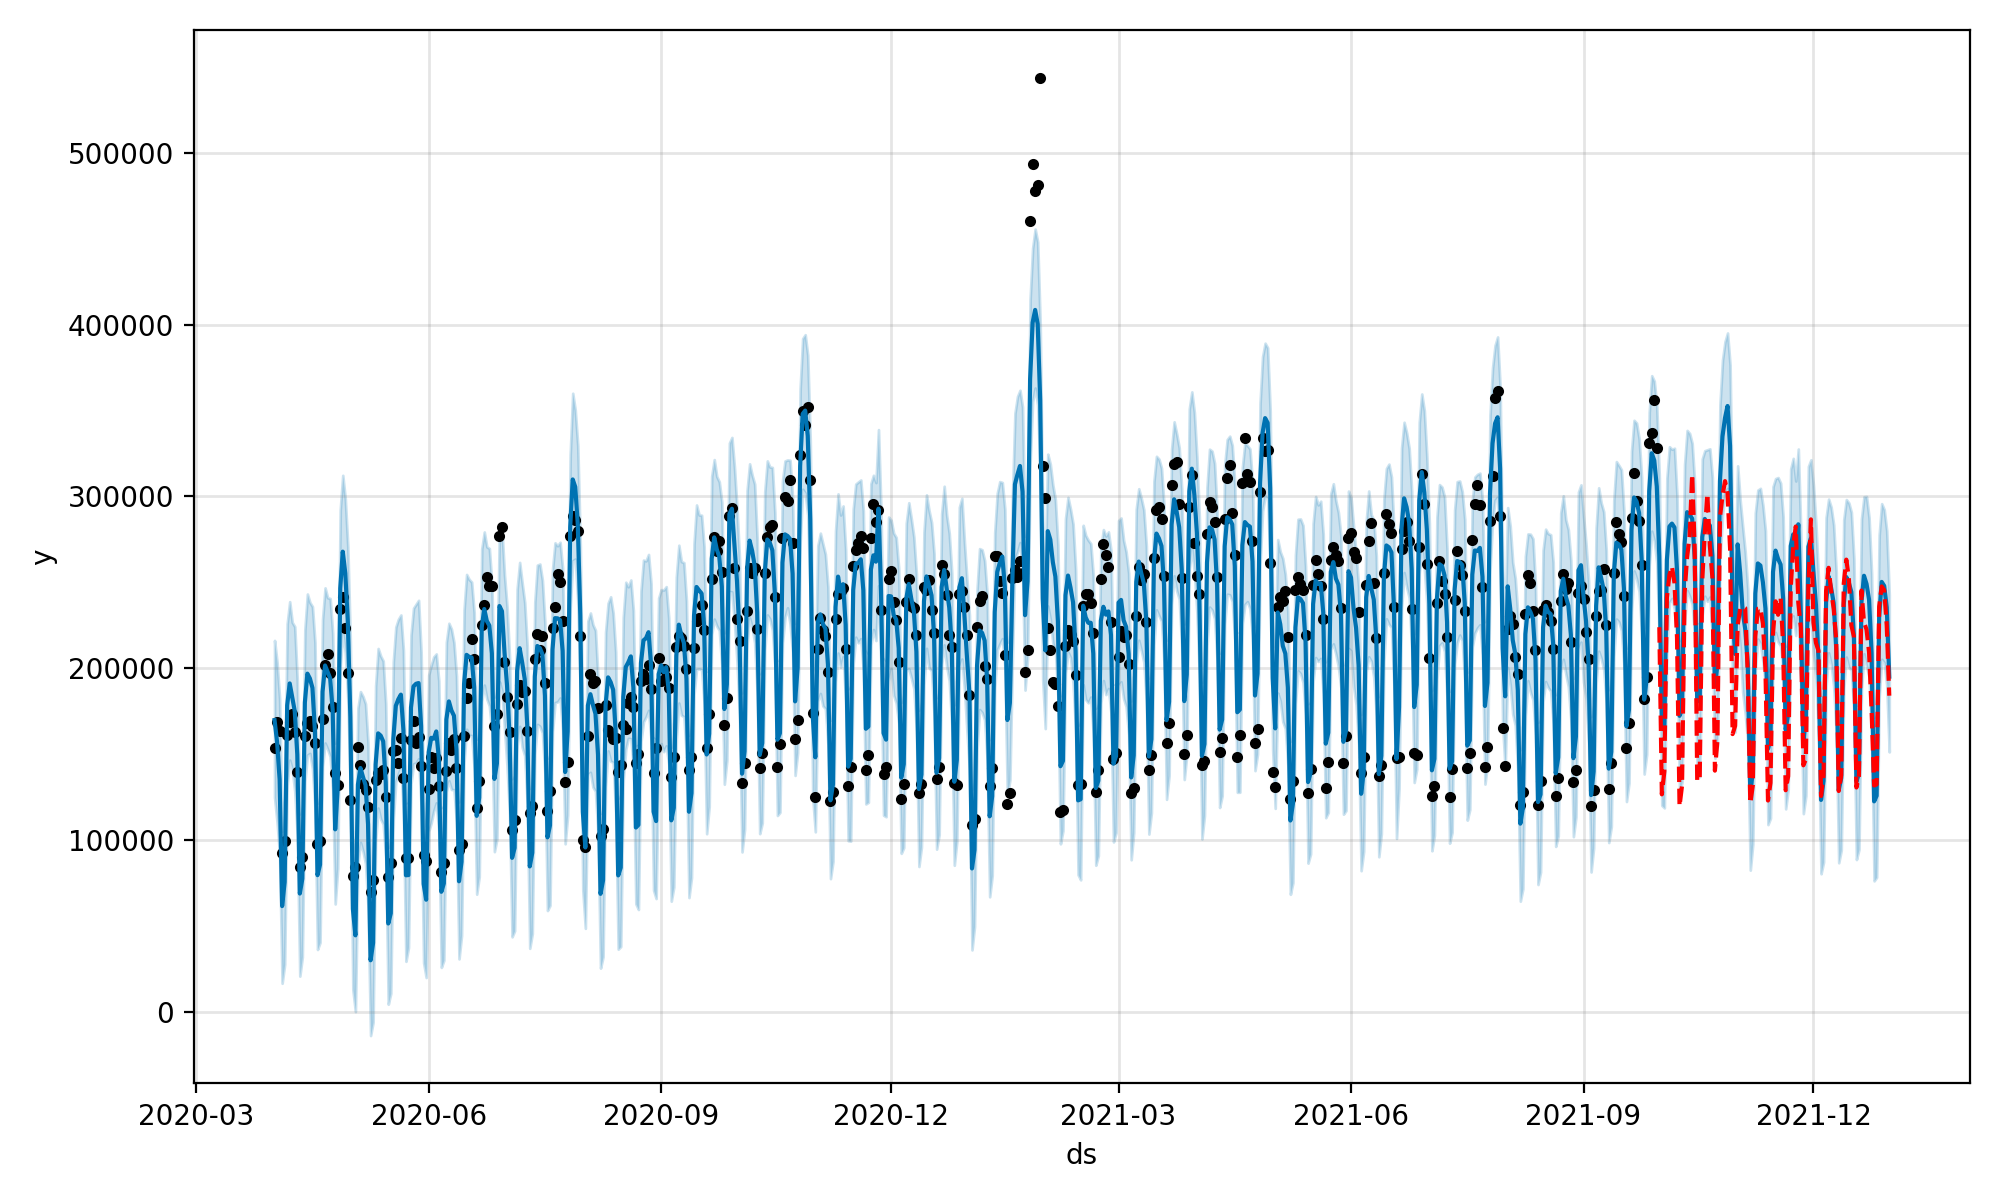

In [24]:
fig1 = model.plot(forecast)
plt.plot(bb['ds'],bb['y'],'r--')

<IPython.core.display.Javascript object>


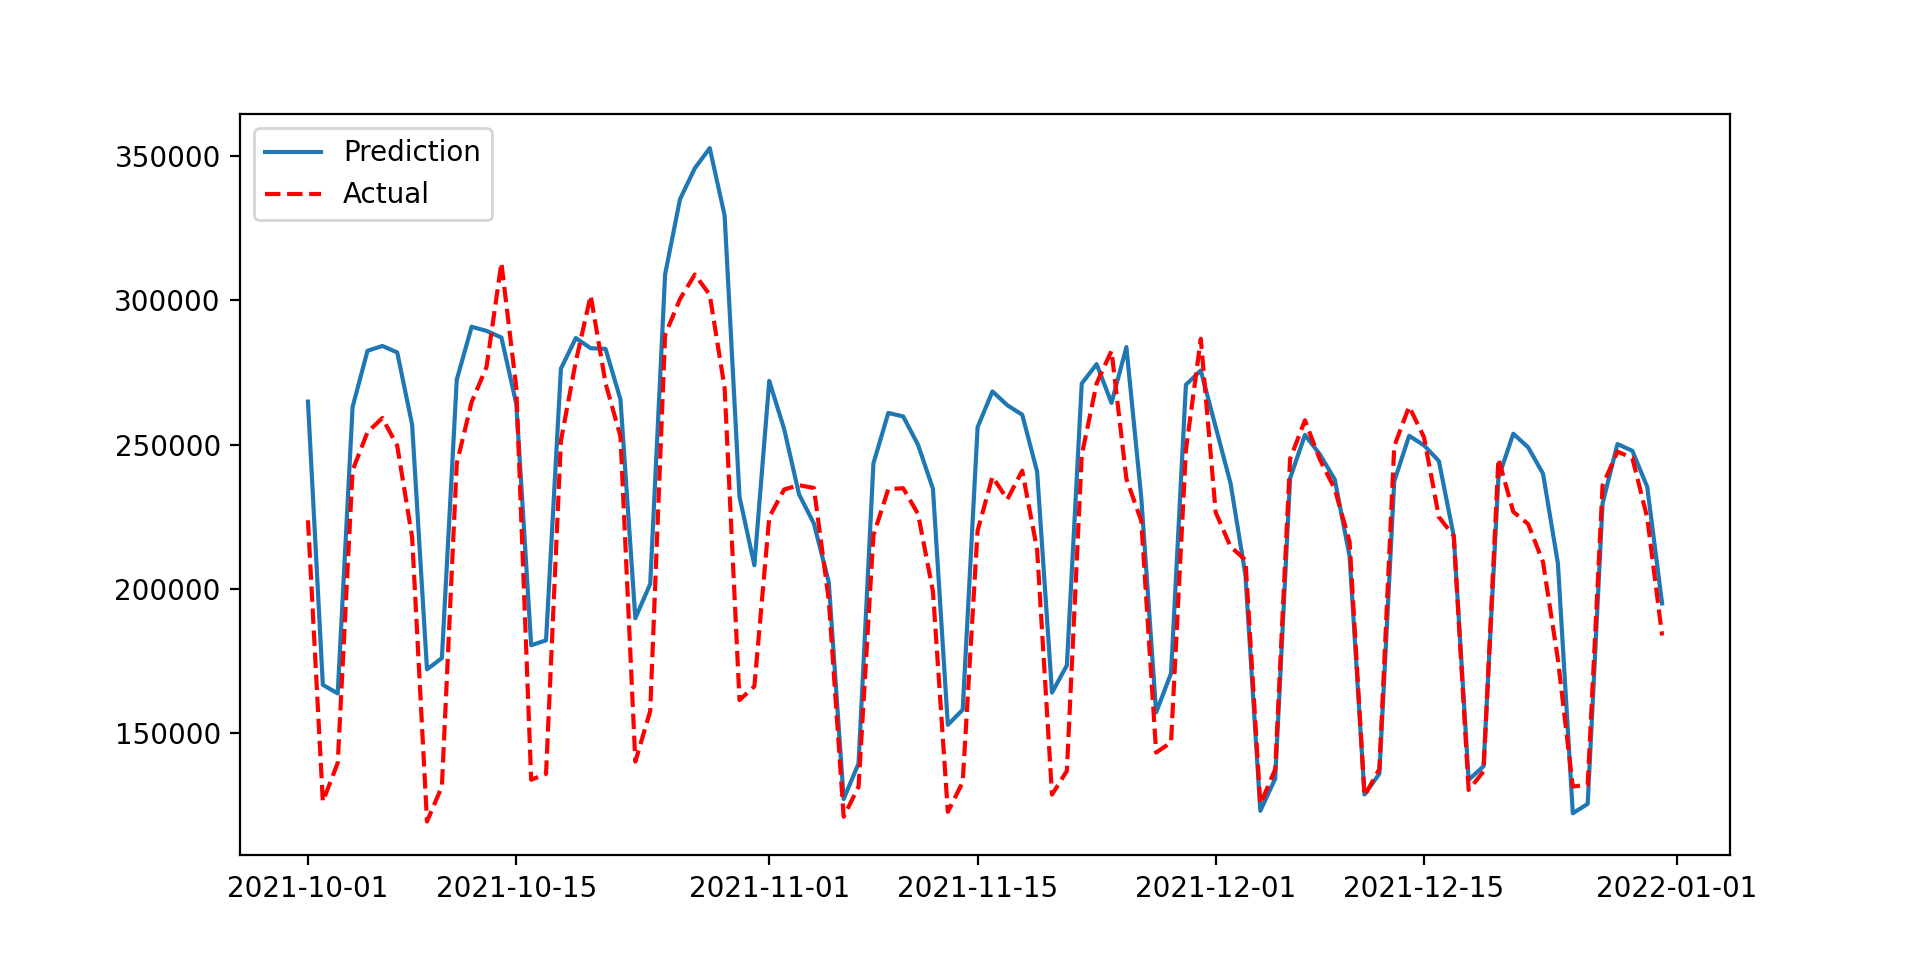

In [25]:
plt.plot(bb['ds'],bb['yhat'], label = 'Prediction')
plt.plot(bb['ds'],bb['y'],'r--', label = 'Actual')
plt.legend(loc="upper left")

In [26]:
bb['yhat'].sum()

21299605.4714881

In [27]:
bb['y'].sum()

19634307.184637003

In [28]:
(21299605.4714881-19634307.184637003)/19634307.184637003

0.08481573967397846

In [29]:
bb['yhat_lower'].sum()

17097973.48995955

In [30]:
bb['yhat_upper'].sum()

25513409.585945502

<IPython.core.display.Javascript object>


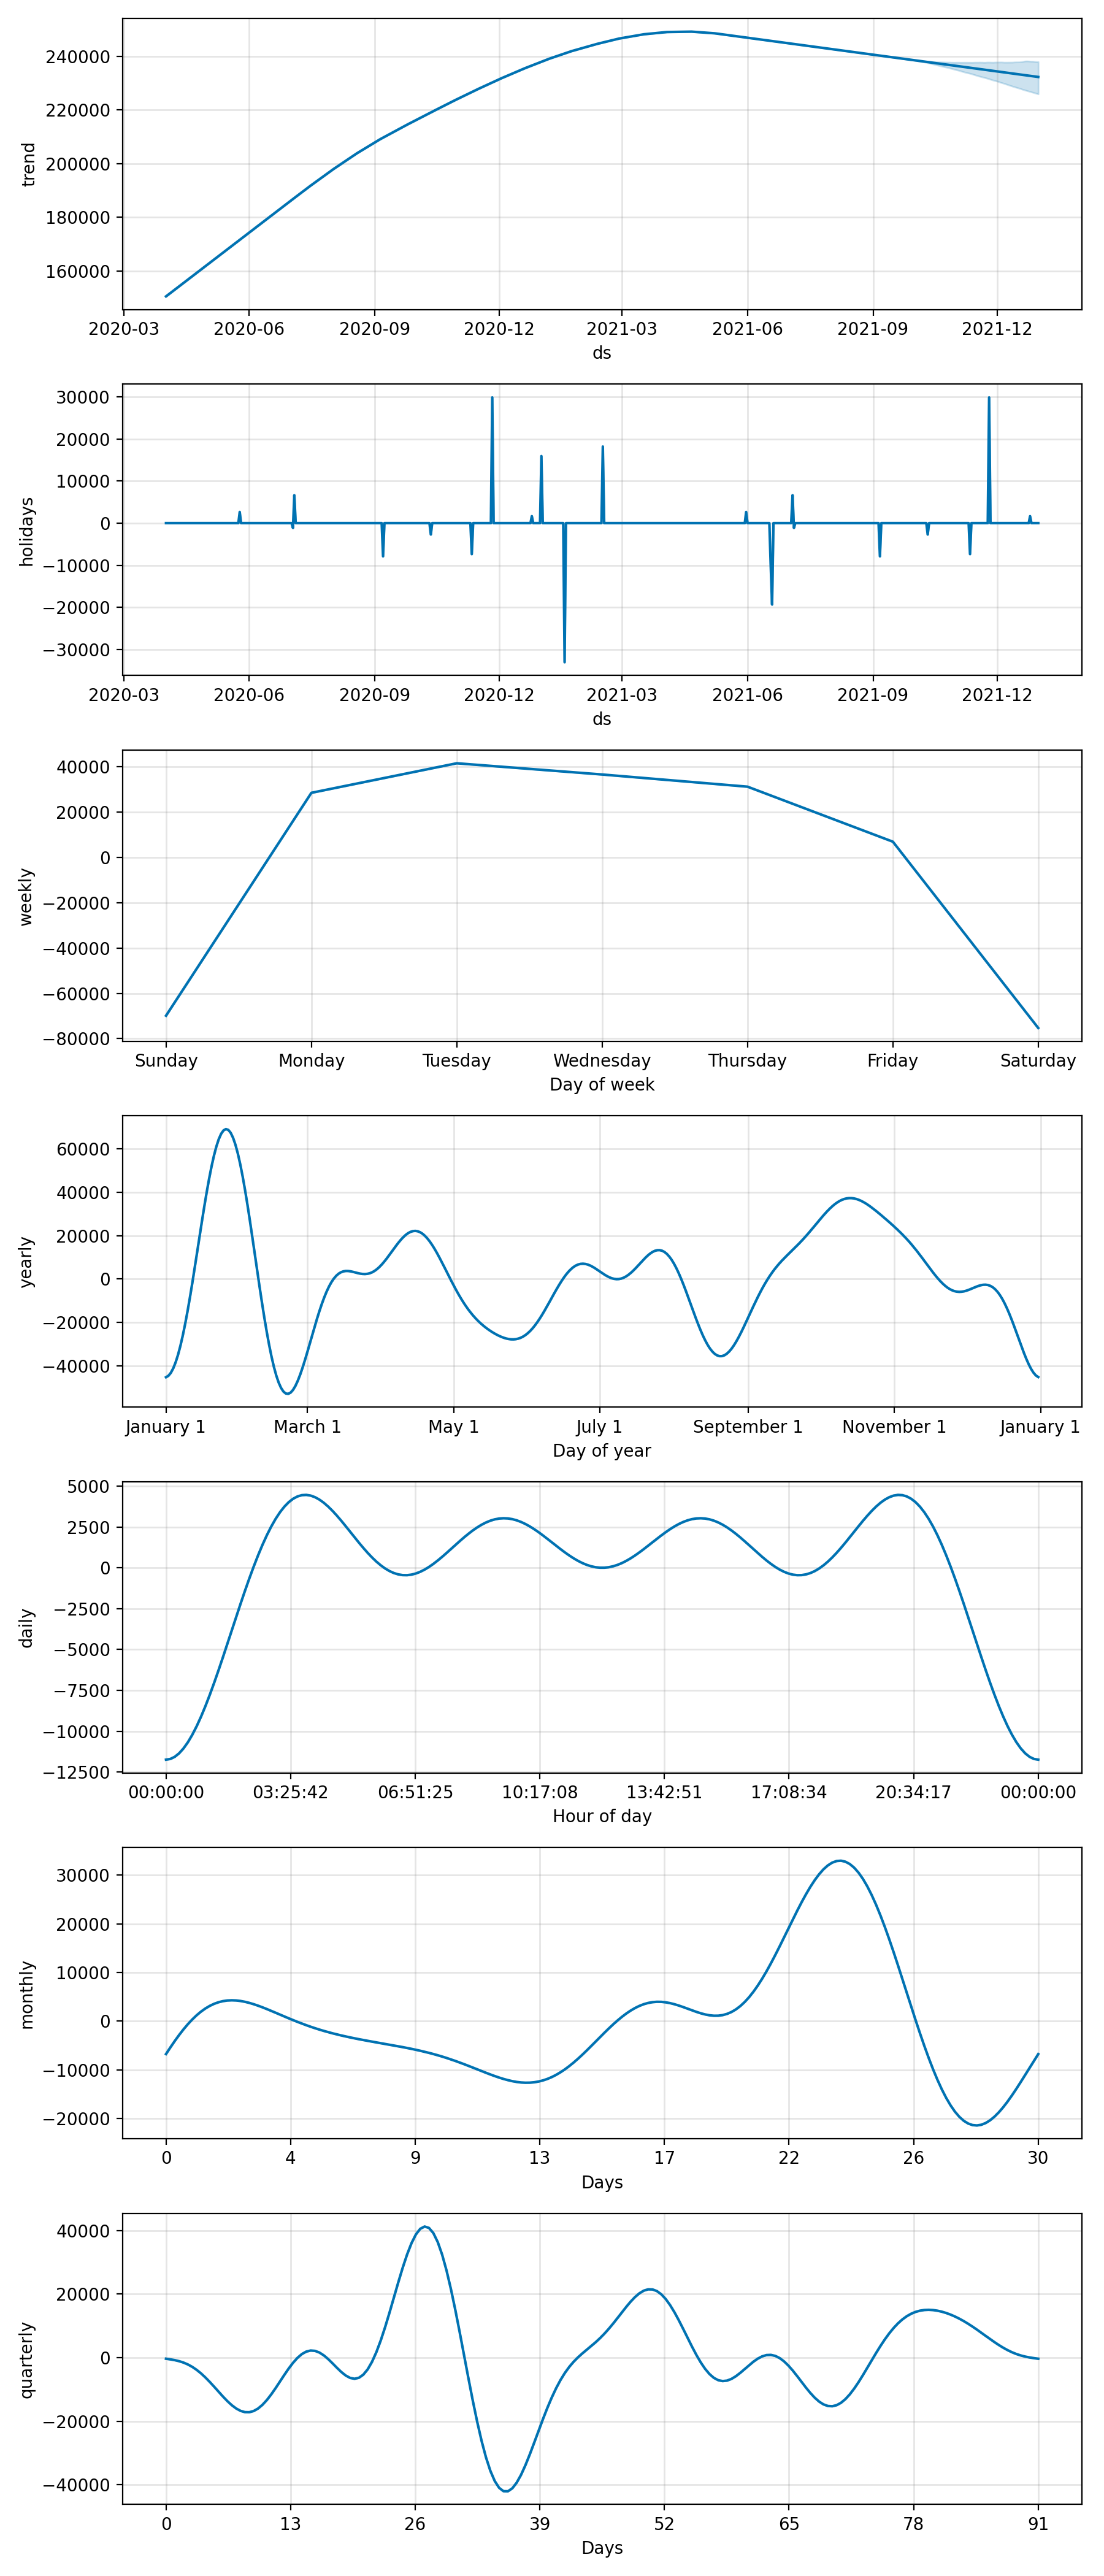

In [31]:
fig2 = model.plot_components(forecast)

# Weekly Prediction model

In [32]:
model = Prophet(seasonality_mode='additive', interval_width=0.95, yearly_seasonality=True)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)
model.add_seasonality(name='quarterly', period=91.25, fourier_order=8, prior_scale=0.02)
#model.add_country_holidays(country_name='US')

In [33]:
model.fit(weekly_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -10.0406


Iteration  1. Log joint probability =    69.7096. Improved by 79.7502.
Iteration  2. Log joint probability =     110.27. Improved by 40.5602.
Iteration  3. Log joint probability =    151.954. Improved by 41.6846.
Iteration  4. Log joint probability =    190.449. Improved by 38.4948.
Iteration  5. Log joint probability =    194.012. Improved by 3.56256.
Iteration  6. Log joint probability =    196.913. Improved by 2.90169.
Iteration  7. Log joint probability =    196.956. Improved by 0.0429466.
Iteration  8. Log joint probability =    196.996. Improved by 0.03972.
Iteration  9. Log joint probability =    197.013. Improved by 0.01709.
Iteration 10. Log joint probability =    197.022. Improved by 0.00853665.
Iteration 11. Log joint probability =    197.026. Improved by 0.00426624.
Iteration 12. Log joint probability =    197.055. Improved by 0.0291417.
Iteration 13. Log joint probability =    197.082. Improved by 0.0271062.
Iteration 14. Log joint probability =    197.099. Improved by 0.0

In [34]:
future = model.make_future_dataframe(periods=13, freq = 'W' )
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

ds          yhat    yhat_lower    yhat_upper
87 2021-11-28  1.498640e+06  1.263152e+06  1.741010e+06
88 2021-12-05  1.394468e+06  1.173718e+06  1.612736e+06
89 2021-12-12  1.360249e+06  1.123412e+06  1.591251e+06
90 2021-12-19  1.284870e+06  1.035254e+06  1.517511e+06
91 2021-12-26  1.043506e+06  7.986557e+05  1.290316e+06

In [35]:
aa = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(13)
aa

ds          yhat    yhat_lower    yhat_upper
79 2021-10-03  1.541256e+06  1.293979e+06  1.782866e+06
80 2021-10-10  1.631262e+06  1.385651e+06  1.862650e+06
81 2021-10-17  1.791236e+06  1.554236e+06  2.028629e+06
82 2021-10-24  2.153156e+06  1.919522e+06  2.389924e+06
83 2021-10-31  1.397222e+06  1.167310e+06  1.620299e+06
84 2021-11-07  1.497890e+06  1.254863e+06  1.720338e+06
85 2021-11-14  1.515221e+06  1.281952e+06  1.756974e+06
86 2021-11-21  1.579529e+06  1.359527e+06  1.830634e+06
87 2021-11-28  1.498640e+06  1.263152e+06  1.741010e+06
88 2021-12-05  1.394468e+06  1.173718e+06  1.612736e+06
89 2021-12-12  1.360249e+06  1.123412e+06  1.591251e+06
90 2021-12-19  1.284870e+06  1.035254e+06  1.517511e+06
91 2021-12-26  1.043506e+06  7.986557e+05  1.290316e+06

In [36]:
bb_ = validation_df.resample('W', on = 'ds', label = 'left').sum().reset_index().iloc[1:]
bb_

ds             y
1  2021-10-03  1.473338e+06
2  2021-10-10  1.637794e+06
3  2021-10-17  1.653864e+06
4  2021-10-24  1.796656e+06
5  2021-10-31  1.379304e+06
6  2021-11-07  1.369330e+06
7  2021-11-14  1.410691e+06
8  2021-11-21  1.552163e+06
9  2021-11-28  1.449098e+06
10 2021-12-05  1.465486e+06
11 2021-12-12  1.475855e+06
12 2021-12-19  1.343173e+06
13 2021-12-26  1.137488e+06

In [37]:
bb = pd.merge(aa, bb_, on = 'ds')
bb.head()

ds          yhat    yhat_lower    yhat_upper             y
0 2021-10-03  1.541256e+06  1.293979e+06  1.782866e+06  1.473338e+06
1 2021-10-10  1.631262e+06  1.385651e+06  1.862650e+06  1.637794e+06
2 2021-10-17  1.791236e+06  1.554236e+06  2.028629e+06  1.653864e+06
3 2021-10-24  2.153156e+06  1.919522e+06  2.389924e+06  1.796656e+06
4 2021-10-31  1.397222e+06  1.167310e+06  1.620299e+06  1.379304e+06

<IPython.core.display.Javascript object>


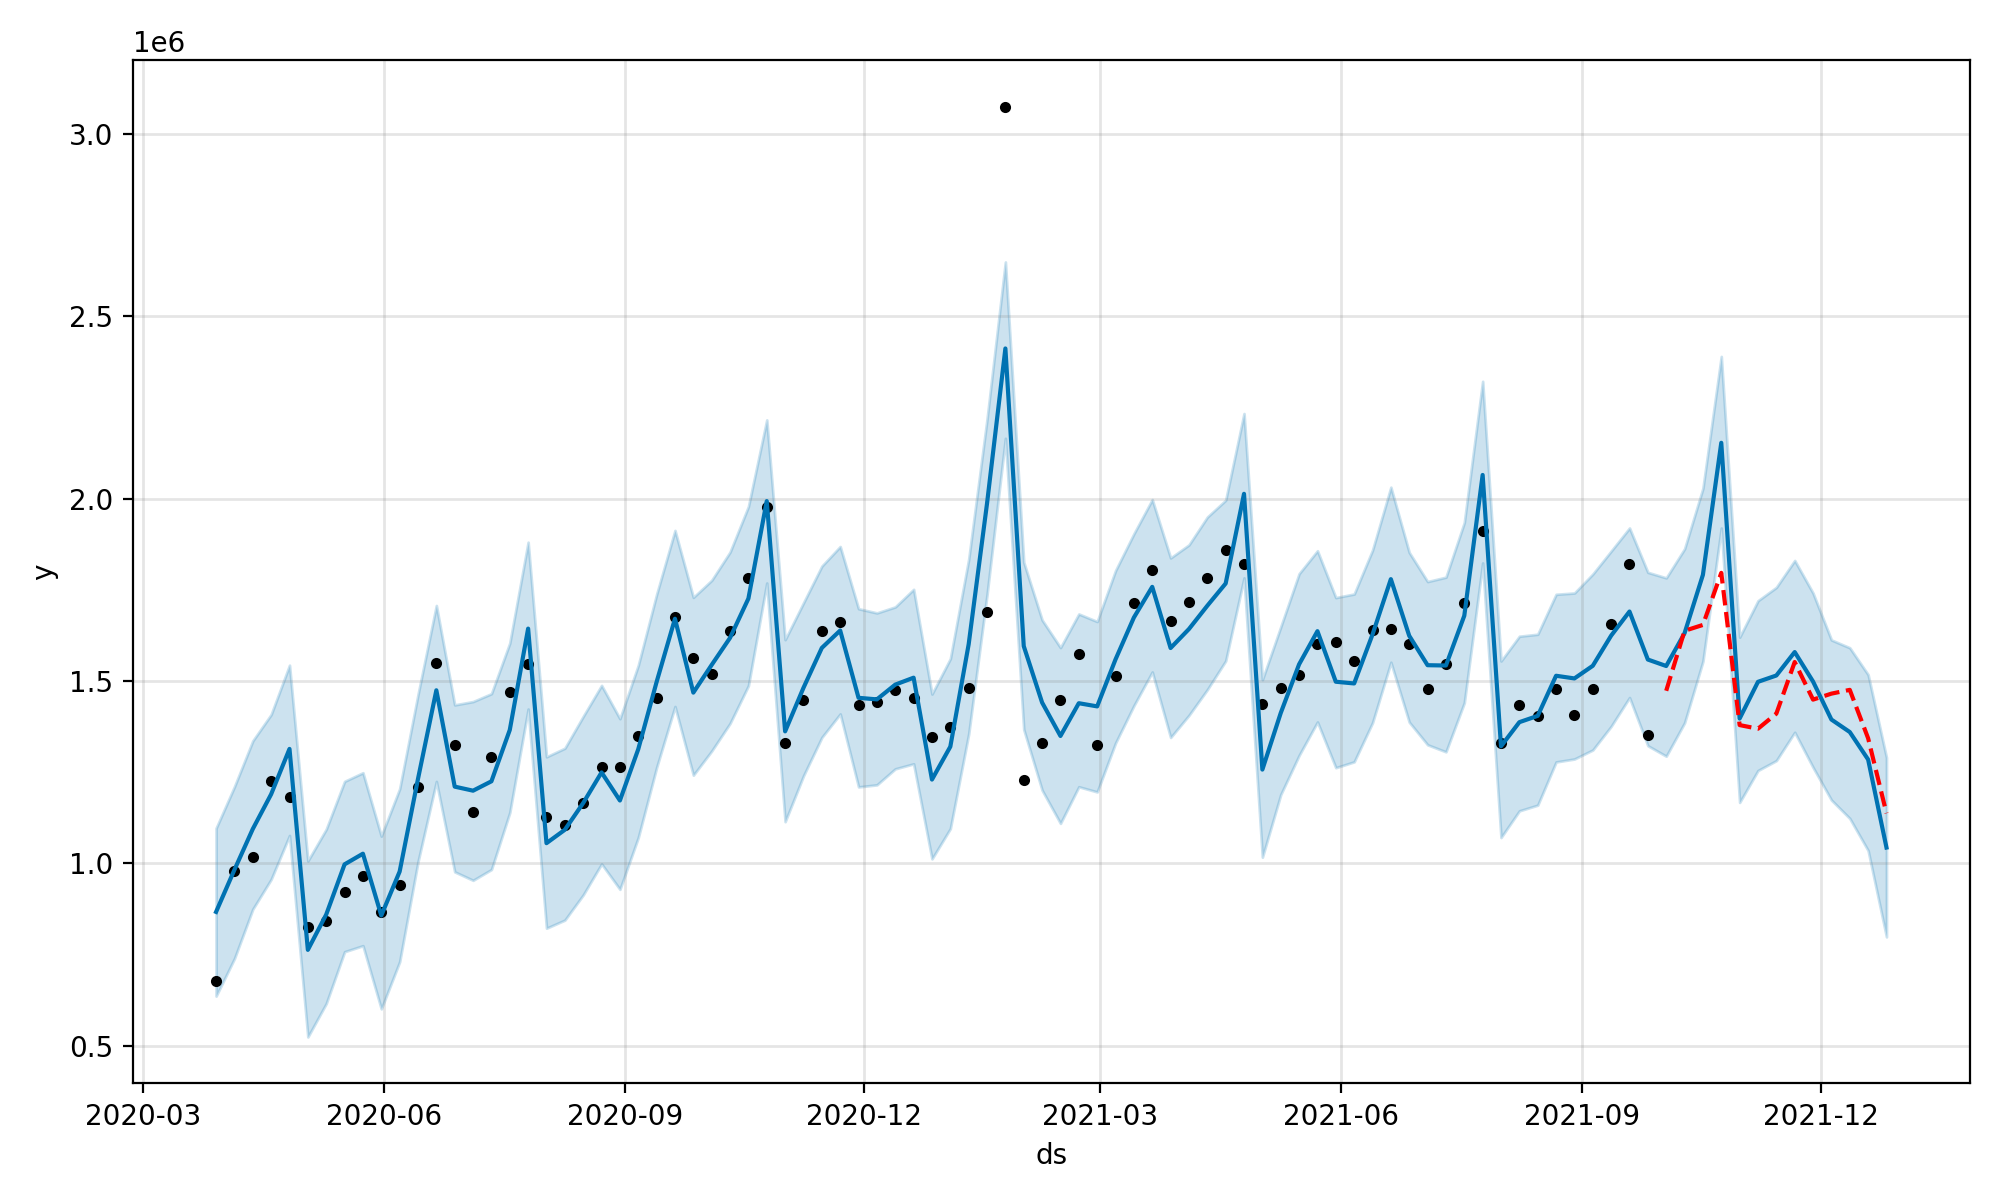

In [38]:
fig1 = model.plot(forecast)
plt.plot(bb['ds'],bb['y'],'r--')

<IPython.core.display.Javascript object>


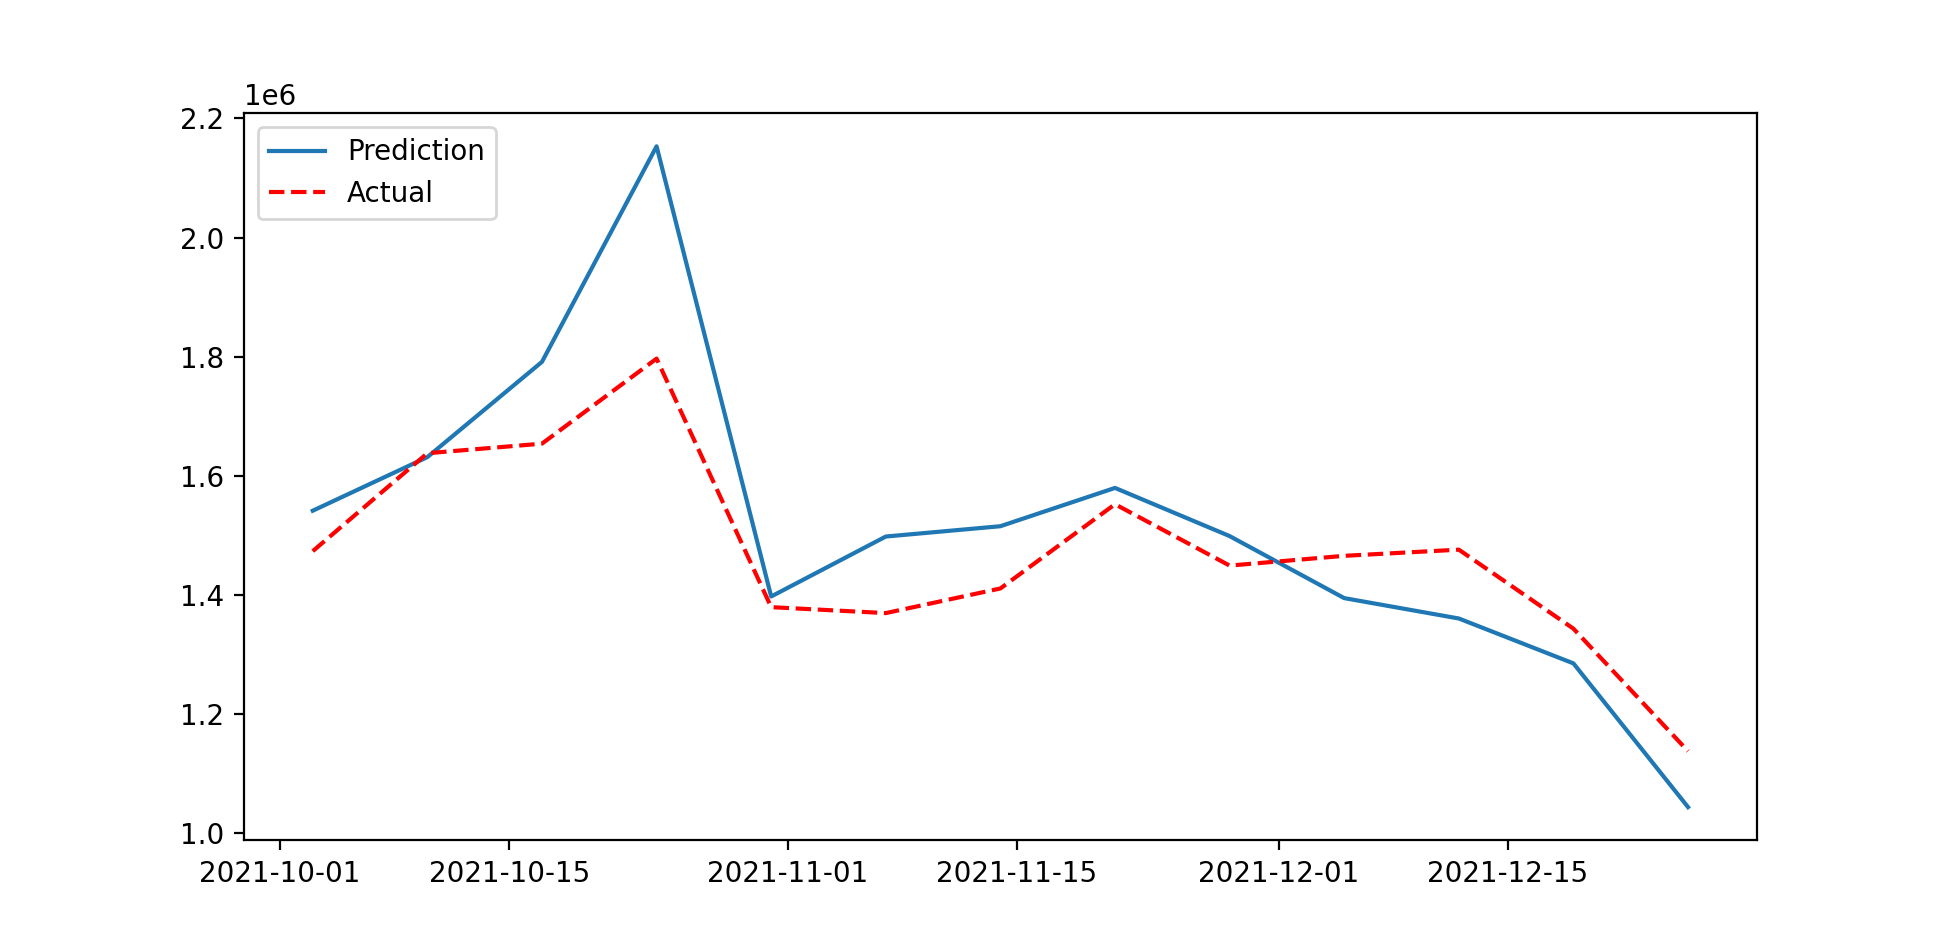

In [39]:
plt.plot(bb['ds'],bb['yhat'], label = 'Prediction')
plt.plot(bb['ds'],bb['y'],'r--', label = 'Actual')
plt.legend(loc="upper left")

In [40]:
bb['yhat'].sum()

19688505.309669897

In [41]:
bb['y'].sum()

19144239.085244

In [42]:
bb['yhat_upper'].sum()

22745135.49072868

In [43]:
bb['yhat_lower'].sum()

16611230.519698082

In [44]:
(19688505.309503507-19144239.085244004)/19144239.085244004

0.02842976531143579

<IPython.core.display.Javascript object>


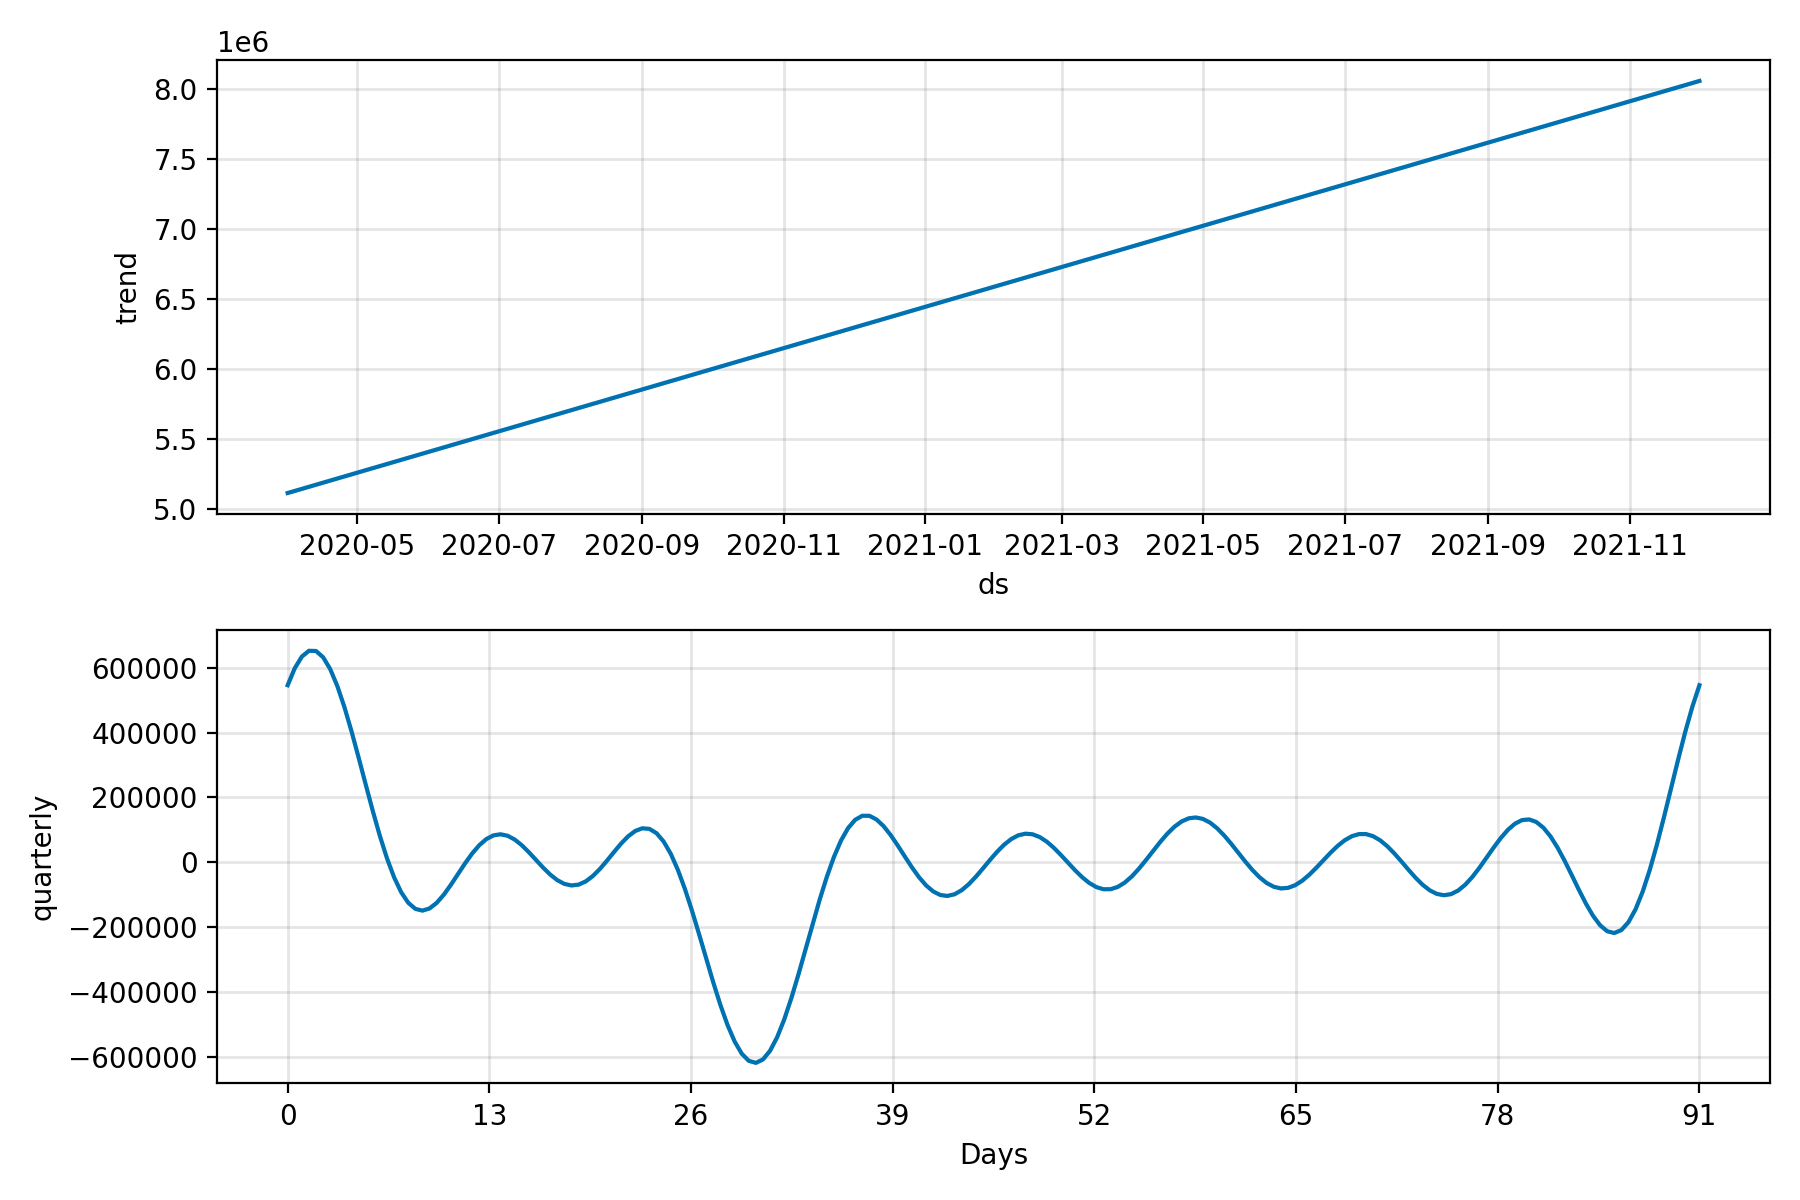

In [53]:
fig2 = model.plot_components(forecast)

# Monthly prediction model

In [46]:
model = Prophet(seasonality_mode='additive', interval_width=0.95)
#model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)
model.add_seasonality(name='quarterly', period=91.25, fourier_order=8, prior_scale=0.02)
#model.add_country_holidays(country_name='US')

In [47]:
model.fit(monthly_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 13.



Initial log joint probability = 53.8815


Iteration  1. Log joint probability =    20.5318. Improved by -33.3497.
Iteration  2. Log joint probability =    30.9449. Improved by 10.413.
Iteration  3. Log joint probability =    36.5583. Improved by 5.61338.
Iteration  4. Log joint probability =    36.9367. Improved by 0.378474.
Iteration  5. Log joint probability =    36.9578. Improved by 0.0210476.
Iteration  6. Log joint probability =    36.9928. Improved by 0.0350376.
Iteration  7. Log joint probability =    37.0079. Improved by 0.0150685.
Iteration  8. Log joint probability =    37.0165. Improved by 0.00862386.
Iteration  9. Log joint probability =    37.0243. Improved by 0.00780786.
Iteration 10. Log joint probability =    37.0281. Improved by 0.0038268.
Iteration 11. Log joint probability =    37.0349. Improved by 0.00674192.
Iteration 12. Log joint probability =    37.0366. Improved by 0.00168513.
Iteration 13. Log joint probability =    37.0412. Improved by 0.00463276.
Iteration 14. Log joint probability =    37.0421. Imp

In [48]:
future = model.make_future_dataframe(periods=3, freq = 'MS' )
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

ds          yhat    yhat_lower    yhat_upper
16 2021-08-01  6.854304e+06  5.677497e+06  7.972884e+06
17 2021-09-01  7.646158e+06  6.561339e+06  8.737586e+06
18 2021-10-01  8.342241e+06  7.282896e+06  9.466454e+06
19 2021-11-01  7.338714e+06  6.236007e+06  8.401674e+06
20 2021-12-01  8.101514e+06  7.001469e+06  9.186658e+06

In [49]:
aa = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [50]:
bb_ = validation_df.resample('MS', on = 'ds').sum().reset_index()

In [51]:
bb = pd.merge(aa, bb_, on = 'ds')
bb.head()

ds          yhat    yhat_lower    yhat_upper             y
0 2021-10-01  8.342241e+06  7.282896e+06  9.466454e+06  7.051720e+06
1 2021-11-01  7.338714e+06  6.236007e+06  8.401674e+06  6.246169e+06
2 2021-12-01  8.101514e+06  7.001469e+06  9.186658e+06  6.336418e+06

<IPython.core.display.Javascript object>


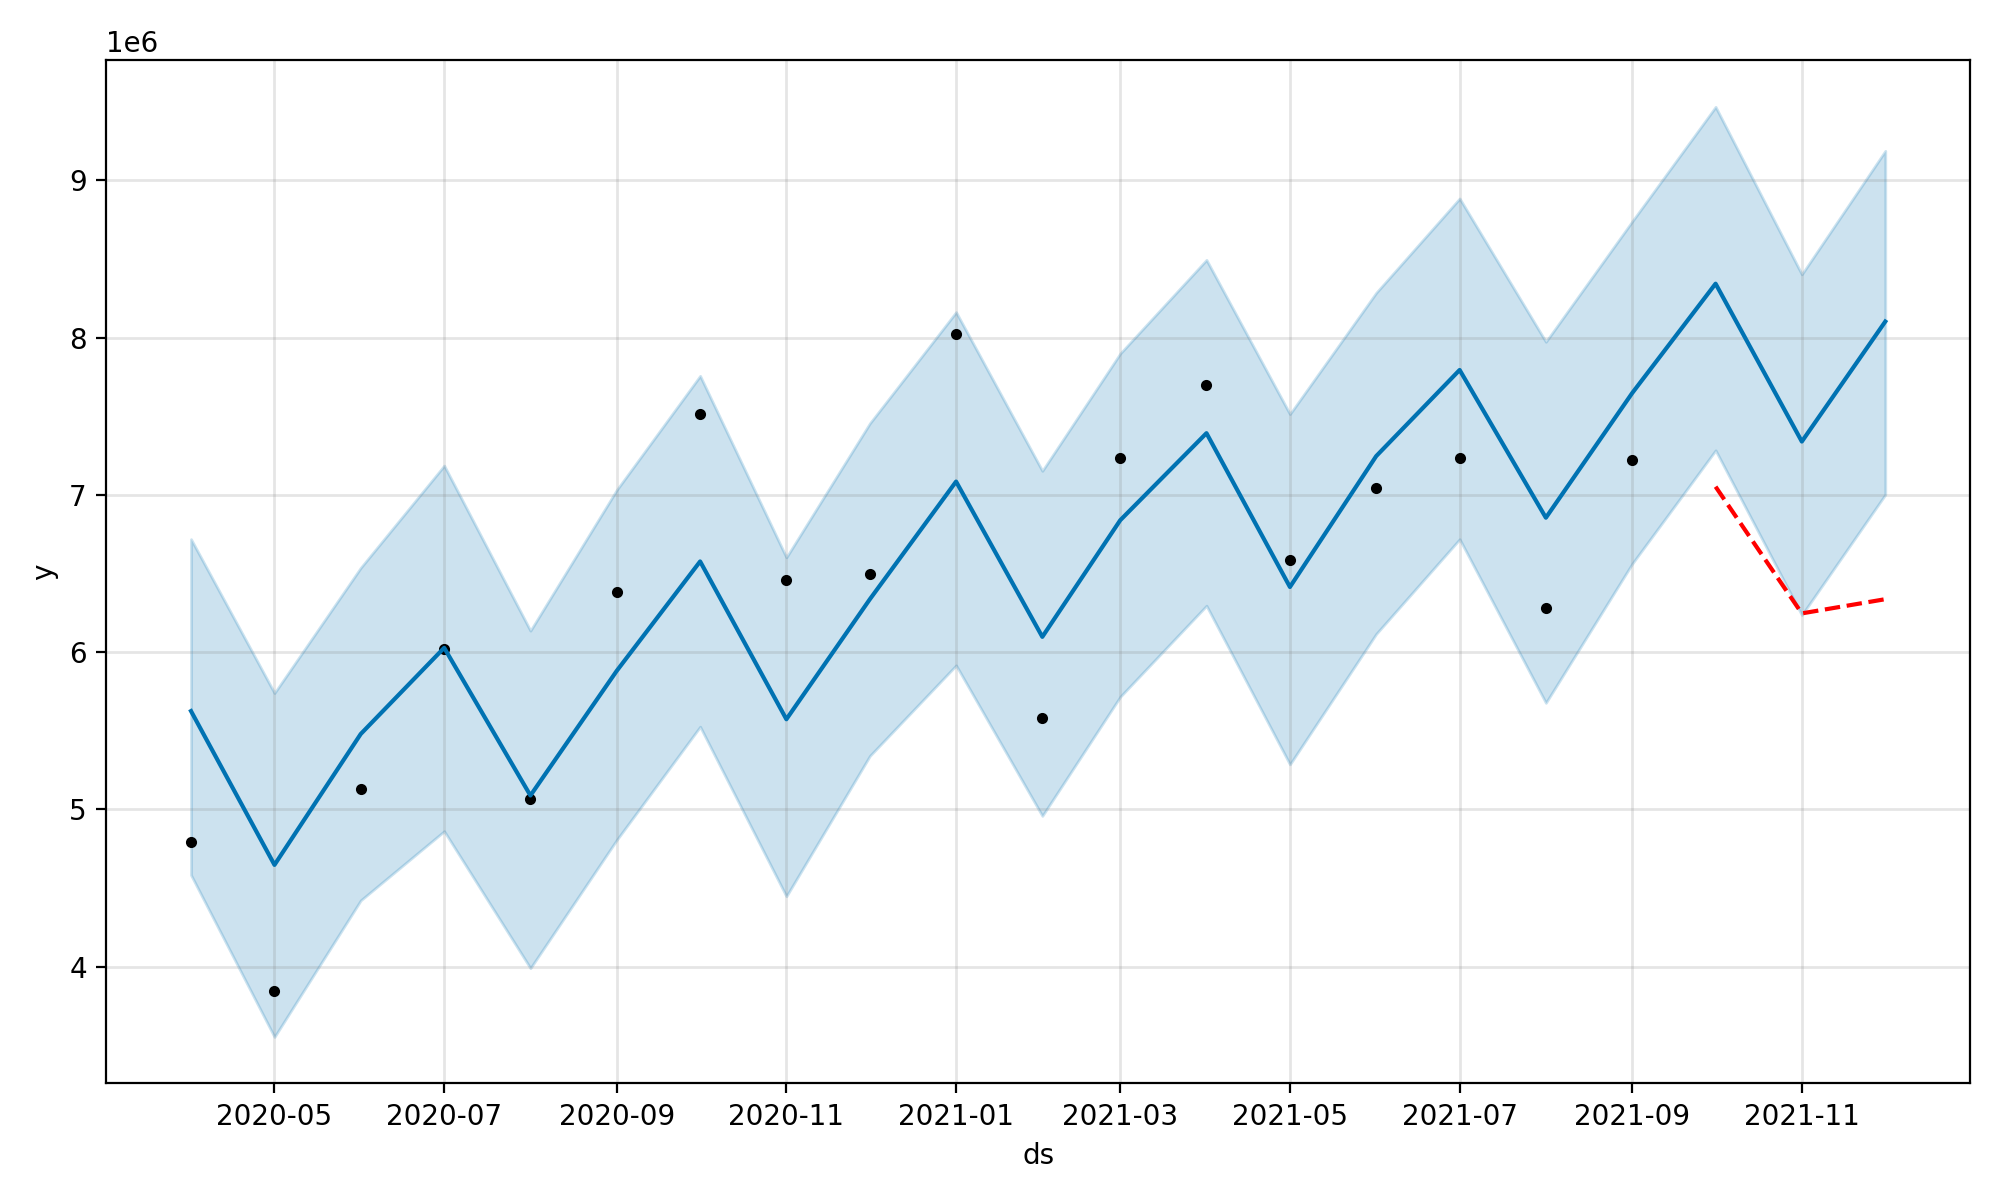

In [57]:
fig1 = model.plot(forecast)
plt.plot(bb['ds'],bb['y'],'r--')

<IPython.core.display.Javascript object>


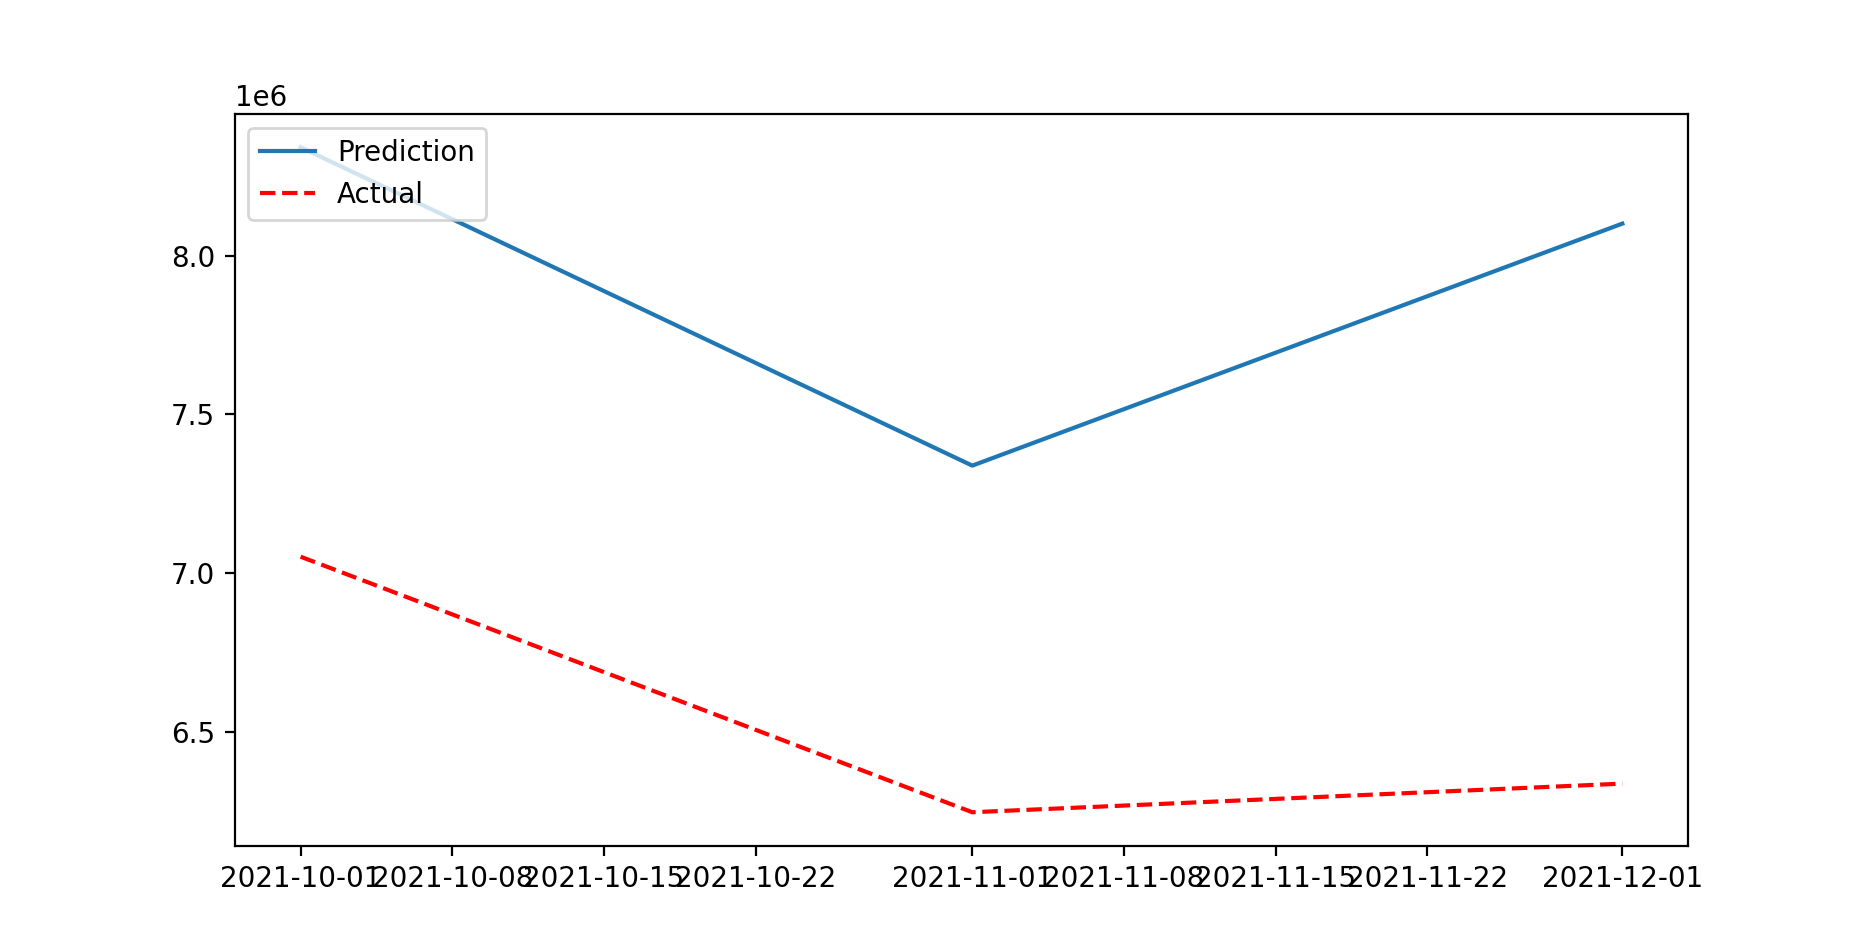

In [58]:
plt.plot(bb['ds'],bb['yhat'], label = 'Prediction')
plt.plot(bb['ds'],bb['y'],'r--', label = 'Actual')
plt.legend(loc="upper left")

In [59]:
bb['yhat'].sum()

23782468.38739642

In [60]:
bb['y'].sum()

19634307.184637003

In [61]:
bb['yhat_upper'].sum()

27054785.54688739

In [62]:
bb['yhat_lower'].sum()

20520371.827705223

In [63]:
(23782468.38739674-19634307.184637003)/19634307.184637003

0.21127107586487676

<IPython.core.display.Javascript object>


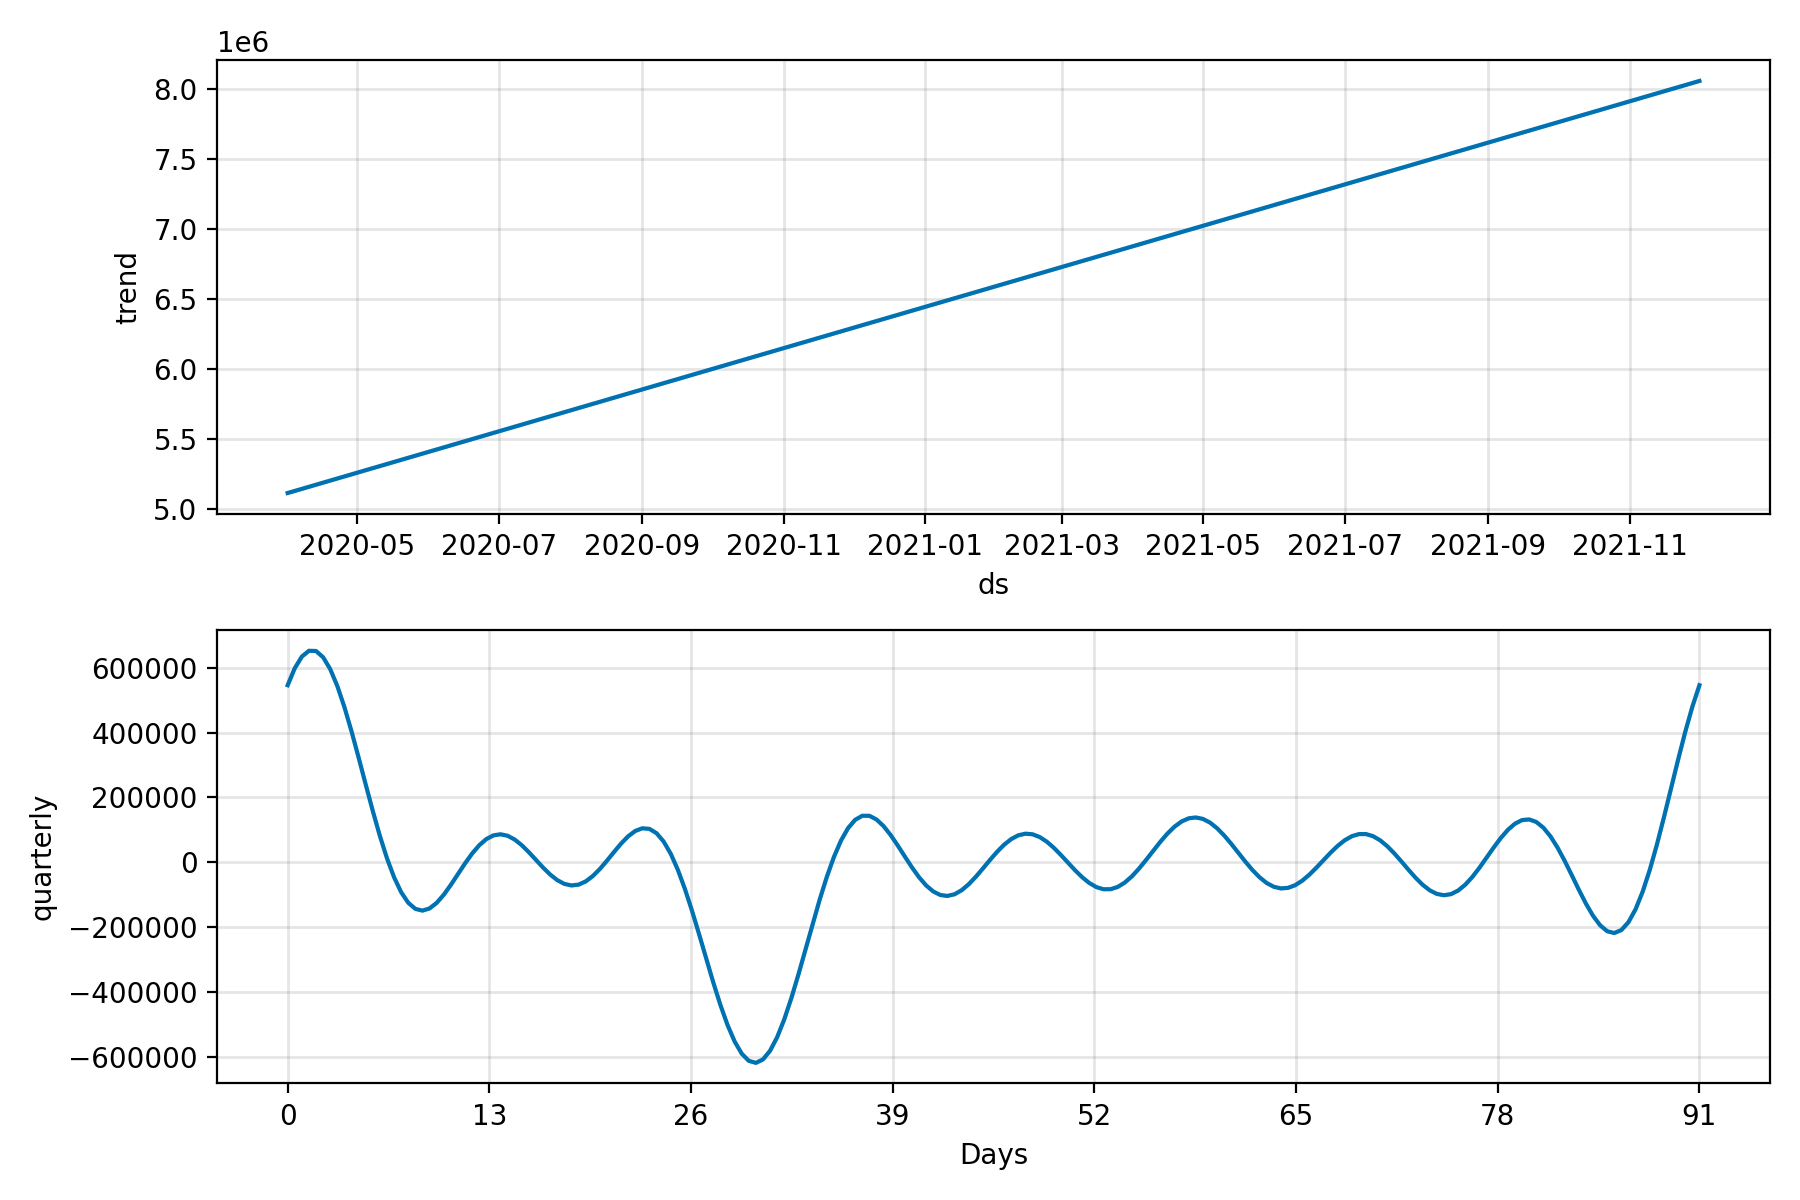

In [64]:
fig2 = model.plot_components(forecast)